Input beam is an efield UVBeam but beam_type is specified as 'power'. Converting efield beam to power.


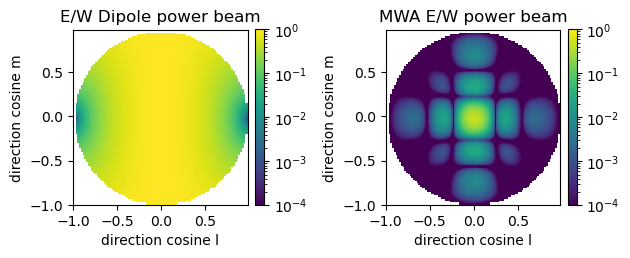

In [1]:
  >>> import os
  >>> import matplotlib.pyplot as plt
  >>> import numpy as np
  >>> from matplotlib.colors import LogNorm

  >>> from pyuvdata import ShortDipoleBeam, BeamInterface, UVBeam
  >>> from pyuvdata.data import DATA_PATH

  >>> filename = os.path.join(DATA_PATH, "mwa_full_EE_test.h5")

  >>> dipole_beam = BeamInterface(ShortDipoleBeam(), beam_type="power")
  >>> mwa_beam = BeamInterface(UVBeam.from_file(filename, pixels_per_deg=1), beam_type="power")

  >>> # set up zenith angle, azimuth and frequency arrays to evaluate with
  >>> # make a regular grid in direction cosines for nice plots
  >>> n_vals = 100
  >>> zmax = np.radians(90)  # Degrees
  >>> axis_arr = np.arange(-n_vals/2., n_vals/2.) / float(n_vals/2.)
  >>> l_arr, m_arr = np.meshgrid(axis_arr, axis_arr)
  >>> radius = np.sqrt(l_arr**2 + m_arr**2)
  >>> za_array = radius * zmax
  >>> az_array = np.arctan2(m_arr, l_arr)

  >>> # Wrap the azimuth array to [0, 2pi] to match the extent of the UVBeam azimuth
  >>> where_neg_az = np.nonzero(az_array < 0)
  >>> az_array[where_neg_az] = az_array[where_neg_az] + np.pi * 2.
  >>> az_array = az_array.flatten()
  >>> za_array = za_array.flatten()

  >>> # find the values above the horizon so we don't try to interpolate the MWA beam
  >>> # beyond the horizon
  >>> above_hor = np.nonzero(za_array <= np.pi / 2.)[0]
  >>> dipole_beam_vals = np.full((1, 4, 1, n_vals * n_vals), np.inf, dtype=complex)
  >>> mwa_beam_vals = np.full((1, 4, 1, n_vals * n_vals), np.inf, dtype=complex)

  >>> # The MWA beam we have in our test data is small, it only has 3 frequencies,
  >>> # so we will just get the value at one of those frequencies rather than
  >>> # trying to interpolate to a new frequency.
  >>> freqs = np.array([mwa_beam.beam.freq_array[-1]])

  >>> dipole_beam_vals[:, :, :, above_hor] = dipole_beam.compute_response(
  ...     az_array=az_array[above_hor], za_array=za_array[above_hor], freq_array=freqs
  ... )
  >>> dipole_beam_vals = dipole_beam_vals.reshape(4, n_vals, n_vals)

  >>> mwa_beam_vals[:, :, :, above_hor] = mwa_beam.compute_response(
  ...     az_array=az_array[above_hor], za_array=za_array[above_hor], freq_array=freqs
  ... )
  >>> mwa_beam_vals = mwa_beam_vals.reshape(4, n_vals, n_vals)

  >>> fig, ax = plt.subplots(1, 2)
  >>> bp_dip = ax[0].imshow(
  ...   dipole_beam_vals[0].real,
  ...   norm=LogNorm(vmin = 1e-4, vmax =1),
  ...   extent=[np.min(l_arr), np.max(l_arr), np.min(m_arr), np.max(m_arr)],
  ... )
  >>> _ = ax[0].set_title(f"E/W Dipole power beam")
  >>> _ = ax[0].set_xlabel("direction cosine l")
  >>> _ = ax[0].set_ylabel("direction cosine m")
  >>> _ = fig.colorbar(bp_dip, ax=ax[0], fraction=0.046, pad=0.04)

  >>> bp_mwa = ax[1].imshow(
  ...   mwa_beam_vals[0].real,
  ...   norm=LogNorm(vmin = 1e-4, vmax =1),
  ...   extent=[np.min(l_arr), np.max(l_arr), np.min(m_arr), np.max(m_arr)],
  ... )
  >>> _ = ax[1].set_title(f"MWA E/W power beam")
  >>> _ = ax[1].set_xlabel("direction cosine l")
  >>> _ = ax[1].set_ylabel("direction cosine m")
  >>> _ = fig.colorbar(bp_mwa, ax=ax[1], fraction=0.046, pad=0.04)
  >>> fig.tight_layout()
